# Random Forest for Expected Goals (xG) Modeling


This notebook applies a **Random Forest Regressor** to estimate **expected goals (xG)** using dataset **DS4**.  
Unlike Linear Regression, Random Forest can capture **non-linear relationships** and **feature interactions**, making it well-suited for the complexity of football data.  

Random Forest is an ensemble of decision trees trained on different subsets of the data, and its predictions are obtained by averaging across all trees.  
This provides robustness, reduces overfitting, and improves predictive performance compared to individual trees.  

The following evaluation metrics are used to compare with other models:  

- **RMSE (Root Mean Squared Error)** and **MAE (Mean Absolute Error)**, measuring prediction accuracy in absolute terms.  

- **R² (Coefficient of Determination)** and **Explained Variance**, assessing how much of the variance in the target is captured by the model.  

- **Pearson and Spearman Correlation**, quantifying the strength of linear and monotonic relationships between predicted and true values.  

- **Calibration Curve**, providing a graphical evaluation of how closely predicted probabilities align with observed values across probability bins.

This model serves as a more flexible alternative to the baseline Linear Regression, expected to capture **non-linear effects of distance, angle, pressure, and defender positioning** more effectively.


#### Imports and global settings

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
from scipy.stats import pearsonr, spearmanr
from sklearn.model_selection import train_test_split

import os
import random

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

# Display options
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", lambda x: f"{x:,.4f}")

# Output paths
OUTPUT_DIR = "../task1_xg/outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Model directory
MODEL_DIR = "../task1_xg/models"
os.makedirs(MODEL_DIR, exist_ok=True)

print("Setup complete. Ready to load data.")

Setup complete. Ready to load data.


####  Load dataset DS4

In [14]:
DATA_PATH = "../task1_xg/data/DS4.csv"
ds4 = pd.read_csv(DATA_PATH)

print(f"Dataset loaded: {ds4.shape[0]} rows, {ds4.shape[1]} columns")
print("Columns:", list(ds4.columns))

# Preview first rows
ds4.head()

Dataset loaded: 86833 rows, 26 columns
Columns: ['minute', 'second', 'period', 'shot_type', 'shot_technique', 'shot_body_part', 'play_pattern', 'under_pressure', 'shot_first_time', 'shot_one_on_one', 'target_xg', 'loc_x', 'loc_y', 'end_shot_x', 'end_shot_y', 'end_shot_z', 'end_shot_z_available', 'shot_from_set_piece', 'distance_to_goal', 'angle_to_goal', 'gender', 'role', 'num_players_between', 'closest_defender_dist', 'goalkeeper_positioning', 'free_proj_goal']


,minute,second,period,shot_type,shot_technique,shot_body_part,play_pattern,under_pressure,shot_first_time,shot_one_on_one,target_xg,loc_x,loc_y,end_shot_x,end_shot_y,end_shot_z,end_shot_z_available,shot_from_set_piece,distance_to_goal,angle_to_goal,gender,role,num_players_between,closest_defender_dist,goalkeeper_positioning,free_proj_goal
0,0.0435,0.8136,2,3,1,3,2,False,True,False,0.0566,0.7774,0.4366,0.6561,0.4393,0.0000,False,False,0.2143,0.1293,1,3,0.3077,0.0104,0.0132,0.7132
1,0.0507,0.6780,2,3,1,1,1,True,True,False,0.1434,0.9347,0.4166,0.9645,0.4456,0.1364,True,False,0.0871,0.2250,1,0,0.0769,0.0079,0.0123,0.3670
2,0.0797,0.1356,2,3,1,1,2,False,True,False,0.0382,0.8416,0.6964,0.8766,0.5845,0.0000,False,False,0.2227,0.0865,1,0,0.1538,0.0329,0.0068,0.5547
3,0.0942,0.2712,2,3,1,0,2,False,False,False,0.0528,0.9269,0.5910,0.8897,0.5845,0.0000,False,False,0.0995,0.1940,1,0,0.0769,0.0071,0.0045,0.5316
4,0.1159,0.0000,2,3,1,1,1,True,False,False,0.0213,0.6534,0.5295,0.6523,0.5156,0.0000,False,False,0.3301,0.0872,1,3,0.2308,0.0208,0.0019,0.7198


####  Define features, target and train/test split

In [15]:
# Define target column
target_column = "target_xg"
train_columns = [col for col in ds4.columns if col != target_column]

X = ds4[train_columns]
y = ds4[target_column]

# Check on target
print("\nTarget (xG) stats:")
print(y.describe())
print(f"Range: {y.min():.4f} - {y.max():.4f}")

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE
)

print(f"\nTraining set: {X_train.shape[0]} rows, {X_train.shape[1]} features")
print(f"Test set:     {X_test.shape[0]} rows, {X_test.shape[1]} features")



Target (xG) stats:
count   86,833.0000
mean         0.0973
std          0.1281
min          0.0002
25%          0.0275
50%          0.0540
75%          0.1060
max          0.9951
Name: target_xg, dtype: float64
Range: 0.0002 - 0.9951

Training set: 69466 rows, 25 features
Test set:     17367 rows, 25 features


#### Training the Random Forest Regressor

To improve upon the linear baseline, a **Random Forest Regressor** is trained on dataset DS4.  

A **RandomizedSearchCV with 5-fold cross-validation** is used to efficiently identify the best set of hyperparameters, optimizing for **Root Mean Squared Error (RMSE)** as the main evaluation metric.  

Unlike GridSearchCV, RandomizedSearchCV explores only a fixed number of randomly selected configurations from the defined search space. This makes the process significantly faster and computationally lighter, while still covering a broad and representative range of parameter values.  

The approach therefore represents a **trade-off between exploration and efficiency**: instead of guaranteeing the absolute best configuration (as GridSearchCV would do by testing everything), RandomizedSearchCV provides a very good configuration with far fewer evaluations, saving substantial time and resources. 

The hyperparameters explored include:  

- `n_estimators`: number of trees in the forest  
- `max_depth`: maximum depth of each tree  
- `min_samples_split`: minimum number of samples required to split an internal node  
- `min_samples_leaf`: minimum number of samples required at a leaf node  
- `max_features`: number of features considered at each split  

At the end of the search, the best model (`best_rf`) is already retrained on the full training set with the optimal hyperparameters, and is then used for prediction and evaluation on both the training and test sets.


In [18]:
from sklearn.model_selection import RandomizedSearchCV

# Define base model
rf = RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1)

# Define parameter distributions
param_dist = {
    "n_estimators": [100, 250, 500, 1000],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2", None]
}

# RandomizedSearchCV
rand_search = RandomizedSearchCV(
    estimator=rf,                           # Random Forest model
    param_distributions=param_dist,         # parameter distributions for hyperparameter tuning
    n_iter=10,                              # number of random combinations to try
    scoring="neg_root_mean_squared_error",  # RMSE as main metric (neg because of sklearn convention)
    cv=5,                                   # cross-validation splitting strategy
    random_state=RANDOM_STATE,              # reproducibility
    n_jobs=-1,                              # parallelization
    verbose=2                               # verbosity level, defines the amount of information displayed during training
)

# Fit
rand_search.fit(X_train, y_train)

# Best model
best_rf = rand_search.best_estimator_
print("\nBest parameters found:", rand_search.best_params_)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END max_depth=30, max_features=None, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time= 1.7min
[CV] END max_depth=30, max_features=None, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time= 1.7min
[CV] END max_depth=30, max_features=None, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time= 1.8min
[CV] END max_depth=30, max_features=None, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time= 1.8min
[CV] END max_depth=30, max_features=None, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time= 1.8min
[CV] END max_depth=10, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.1min
[CV] END max_depth=10, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.1min
[CV] END max_depth=10, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100

In [19]:
def evaluate_predictions(y_true, y_pred, model_name="Model"):
    """
    Evaluate regression performance using a set of metrics
    suitable for probabilistic xG estimation (continuous target in [0, 1]).

    Parameters
    ----------
    y_true : array-like
        Ground truth (true xG values).
    y_pred : array-like
        Predicted xG values.
    model_name : str
        Label to display in output.

    Returns
    -------
    metrics : dict
        Dictionary of metric values.
    """

    metrics = {
        # Root Mean Squared Error (RMSE):
        # sqrt( (1/n) * Σ (y_i - ŷ_i)^2 )
        # Penalizes large errors more strongly; same units as target.
        "RMSE": root_mean_squared_error(y_true, y_pred),

        # Mean Absolute Error (MAE):
        # (1/n) * Σ |y_i - ŷ_i|
        # Robust to outliers; easy to interpret as "average absolute error".
        "MAE": mean_absolute_error(y_true, y_pred),

        # Coefficient of Determination (R²):
        # 1 - (Σ (y_i - ŷ_i)^2) / (Σ (y_i - ȳ)^2)
        # Measures proportion of variance explained by the model.
        "R2": r2_score(y_true, y_pred),

        # Explained Variance Score:
        # 1 - Var(y - ŷ) / Var(y)
        # Similar to R² but less sensitive to bias in predictions.
        "ExplainedVar": explained_variance_score(y_true, y_pred),

        # Pearson Correlation Coefficient:
        # cov(y, ŷ) / (σ_y * σ_ŷ)
        # Measures strength of linear relationship between y_true and y_pred.
        "Pearson": pearsonr(y_true, y_pred)[0],

        # Spearman Rank Correlation:
        # Pearson correlation between rank(y) and rank(ŷ)
        # Captures monotonic (not necessarily linear) relationships.
        "Spearman": spearmanr(y_true, y_pred)[0]
    }

    # Print nicely formatted results
    print(f"\n{model_name} performance:")
    for k, v in metrics.items():
        print(f"{k:>12}: {v:.4f}")

    return metrics


In [20]:
# Predictions
y_train_pred = np.clip(best_rf.predict(X_train), 0, 1)
y_test_pred  = np.clip(best_rf.predict(X_test), 0, 1)

# Evaluate using the same function as before
train_metrics = evaluate_predictions(y_train, y_train_pred, "Random Forest (train)")
test_metrics  = evaluate_predictions(y_test,  y_test_pred,  "Random Forest (test)")



Random Forest (train) performance:
        RMSE: 0.0146
         MAE: 0.0072
          R2: 0.9869
ExplainedVar: 0.9869
     Pearson: 0.9938
    Spearman: 0.9949

Random Forest (test) performance:
        RMSE: 0.0402
         MAE: 0.0199
          R2: 0.9055
ExplainedVar: 0.9055
     Pearson: 0.9517
    Spearman: 0.9696


#### Calibration Analysis

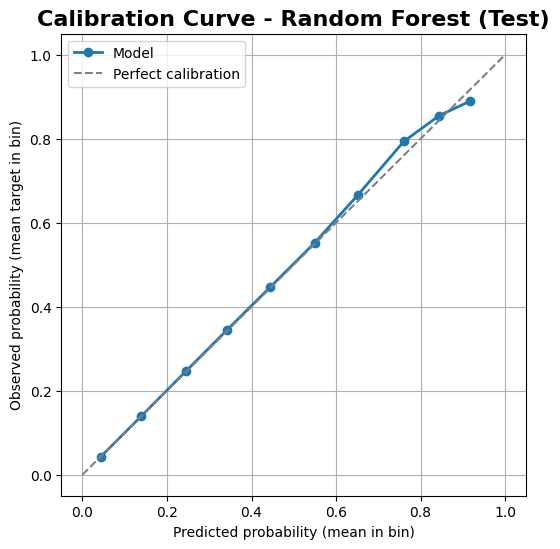

In [21]:
def plot_calibration_continuous(y_true, y_pred, n_bins=10, title="Calibration Curve"):
    # Create bins based on predicted probabilities
    bins = np.linspace(0, 1, n_bins + 1)
    bin_ids = np.digitize(y_pred, bins) - 1

    bin_true = []
    bin_pred = []

    for i in range(n_bins):
        mask = bin_ids == i
        if np.any(mask):
            bin_true.append(y_true[mask].mean())
            bin_pred.append(y_pred[mask].mean())

    # Plot calibration
    plt.figure(figsize=(6, 6))
    plt.plot(bin_pred, bin_true, marker='o', label="Model", linewidth=2)
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Perfect calibration")

    plt.xlabel("Predicted probability (mean in bin)")
    plt.ylabel("Observed probability (mean target in bin)")
    plt.title(title, fontsize=16, fontweight="bold")
    plt.legend()
    plt.grid(True)
    plt.show()

# Run calibration plot on test set
plot_calibration_continuous(y_test.values, y_test_pred, n_bins=10, 
                            title="Calibration Curve - Random Forest (Test)")


#### Features Importance

In [ ]:
def plot_feature_importance(df, title="Feature Importance", top_n=None):
    """
    Plot feature importance for any model in a standardized way.
    
    Parameters
    ----------
    df : DataFrame
        Must contain columns: ['feature', 'importance'] and optionally ['sign'].
        - importance should be normalized to [0,1].
        - sign (optional) should be +1 or -1 to indicate direction of effect.
    title : str
        Title of the plot.
    top_n : int or None
        If set, show only the top N features.
    """

    # Sort by importance
    df = df.sort_values(by="importance", ascending=False)

    # Keep only top_n if requested
    if top_n is not None:
        df = df.tail(top_n)

    # Choose color palette
    if "sign" in df.columns:
        # Diverging colors based on sign
        colors = df["sign"].map({1: "steelblue", -1: "indianred"})
    else:
        # Single-color palette
        colors = "steelblue"

    # Plot
    plt.figure(figsize=(10, max(6, len(df)//3)))
    sns.barplot(data=df, x="importance", y="feature", palette=colors if isinstance(colors, list) else None)
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel("Relative importance (normalized to [0,1])")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

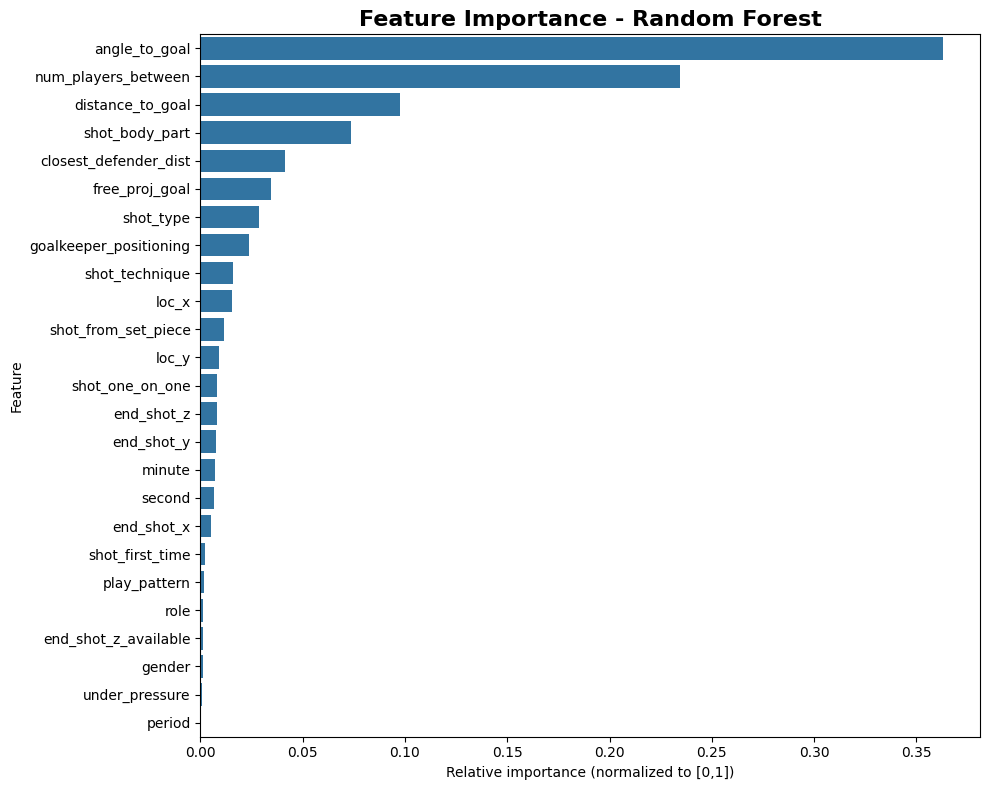

In [24]:
rf_importance = pd.DataFrame({
    "feature": X_train.columns,
    "importance": best_rf.feature_importances_,
    "sign": 1   # no direction in RF (always positive)
}).sort_values(by="importance", ascending=True)

# Plot
plot_feature_importance(rf_importance, title="Feature Importance - Random Forest")


#### Save results and trained model

In [25]:
import joblib

# Save metrics (test set)
results_df = pd.DataFrame([test_metrics], index=["Random Forest (test)"])
results_df.to_csv(f"{OUTPUT_DIR}/metrics_rf.csv", index=True)

# Save model
model_path = f"{MODEL_DIR}/model_rf.pkl"
joblib.dump(best_rf, model_path)

print(f"Metrics saved to {OUTPUT_DIR}/metrics_rf.csv")
print(f"Model saved to {model_path}")

Metrics saved to ../task1_xg/outputs/metrics_rf.csv
Model saved to ../task1_xg/models/model_rf.pkl


## Conclusion

The **Random Forest Regressor** demonstrates a substantial improvement over the linear baseline. On the **training set**, the model achieves an almost perfect fit (R² ≈ 0.99), while on the **test set** it maintains a very strong performance (R² ≈ 0.91).  

This indicates a **slight overfitting**: the model captures nearly all variance in the training data but generalizes slightly less effectively to unseen samples.  

The feature importance analysis confirms the **dominant predictive role of spatial features**, with `angle_to_goal`, `num_players_between`, and `distance_to_goal` emerging as the most influential variables.  

Other contextual factors such as body part, goalkeeper positioning, and defensive pressure contribute meaningfully but with lower relative impact.  

The **calibration curve** shows that the Random Forest predictions are well-aligned with observed outcomes across probability bins, confirming the model’s reliability in producing probability estimates.  

Overall, the Random Forest model achieves a strong balance between **predictive accuracy** and **interpretability**, making it a compelling step forward from the baseline.  
Nevertheless, the slight overfitting suggests room for improvement through **further regularization, feature selection, or the use of more advanced models** (e.g., XGBoost or Neural Networks), which will be explored in the next steps.
